In [442]:
import pandas as pd
import numpy as np
import yfinance as yfin
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Carregamento dos dados

In [443]:
ticket = "PETR4.SA"

In [444]:
data = yfin.download(tickers= ticket, start= datetime(2005,1,1), end= datetime(2021,1,1))

[*********************100%%**********************]  1 of 1 completed


In [445]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,12.187500,12.237500,11.773750,11.775000,2.810848,30044800
2005-01-04,11.873750,11.950000,11.625000,11.635000,2.777429,37667200
2005-01-05,11.662500,11.772500,11.475000,11.590000,2.766685,30873600
2005-01-06,11.652500,11.687500,11.487500,11.625000,2.775040,28224000
2005-01-07,11.648750,11.787500,11.563750,11.676250,2.787275,25980800
...,...,...,...,...,...,...
2020-12-22,27.200001,27.469999,27.049999,27.280001,9.707006,46513200
2020-12-23,27.430000,28.250000,27.350000,27.950001,9.945411,49038900
2020-12-28,28.360001,28.520000,28.180000,28.180000,10.027251,36313300


In [446]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3977 entries, 2005-01-03 to 2020-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3977 non-null   float64
 1   High       3977 non-null   float64
 2   Low        3977 non-null   float64
 3   Close      3977 non-null   float64
 4   Adj Close  3977 non-null   float64
 5   Volume     3977 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 217.5 KB


In [447]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3977.000000,3977.000000,3977.000000,3977.000000,3977.000000,3.977000e+03
mean,21.647976,21.959028,21.306031,21.623410,6.430631,4.702883e+07
std,8.142613,8.232288,8.032465,8.132562,2.275068,7.844114e+07
min,4.200000,4.270000,4.120000,4.200000,1.386508,0.000000e+00
25%,15.850000,16.080000,15.570000,15.820000,4.965998,1.917690e+07
50%,21.225000,21.520000,20.900000,21.200001,6.129639,3.005110e+07
75%,26.440001,26.830000,26.080000,26.450001,7.978117,5.019180e+07
max,52.580002,53.680000,51.950001,52.509998,14.068739,1.336049e+09


In [448]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,12.187500,12.237500,11.773750,11.775000,2.810848,30044800
2005-01-04,11.873750,11.950000,11.625000,11.635000,2.777429,37667200
2005-01-05,11.662500,11.772500,11.475000,11.590000,2.766685,30873600
2005-01-06,11.652500,11.687500,11.487500,11.625000,2.775040,28224000
2005-01-07,11.648750,11.787500,11.563750,11.676250,2.787275,25980800
...,...,...,...,...,...,...
2020-12-22,27.200001,27.469999,27.049999,27.280001,9.707006,46513200
2020-12-23,27.430000,28.250000,27.350000,27.950001,9.945411,49038900
2020-12-28,28.360001,28.520000,28.180000,28.180000,10.027251,36313300


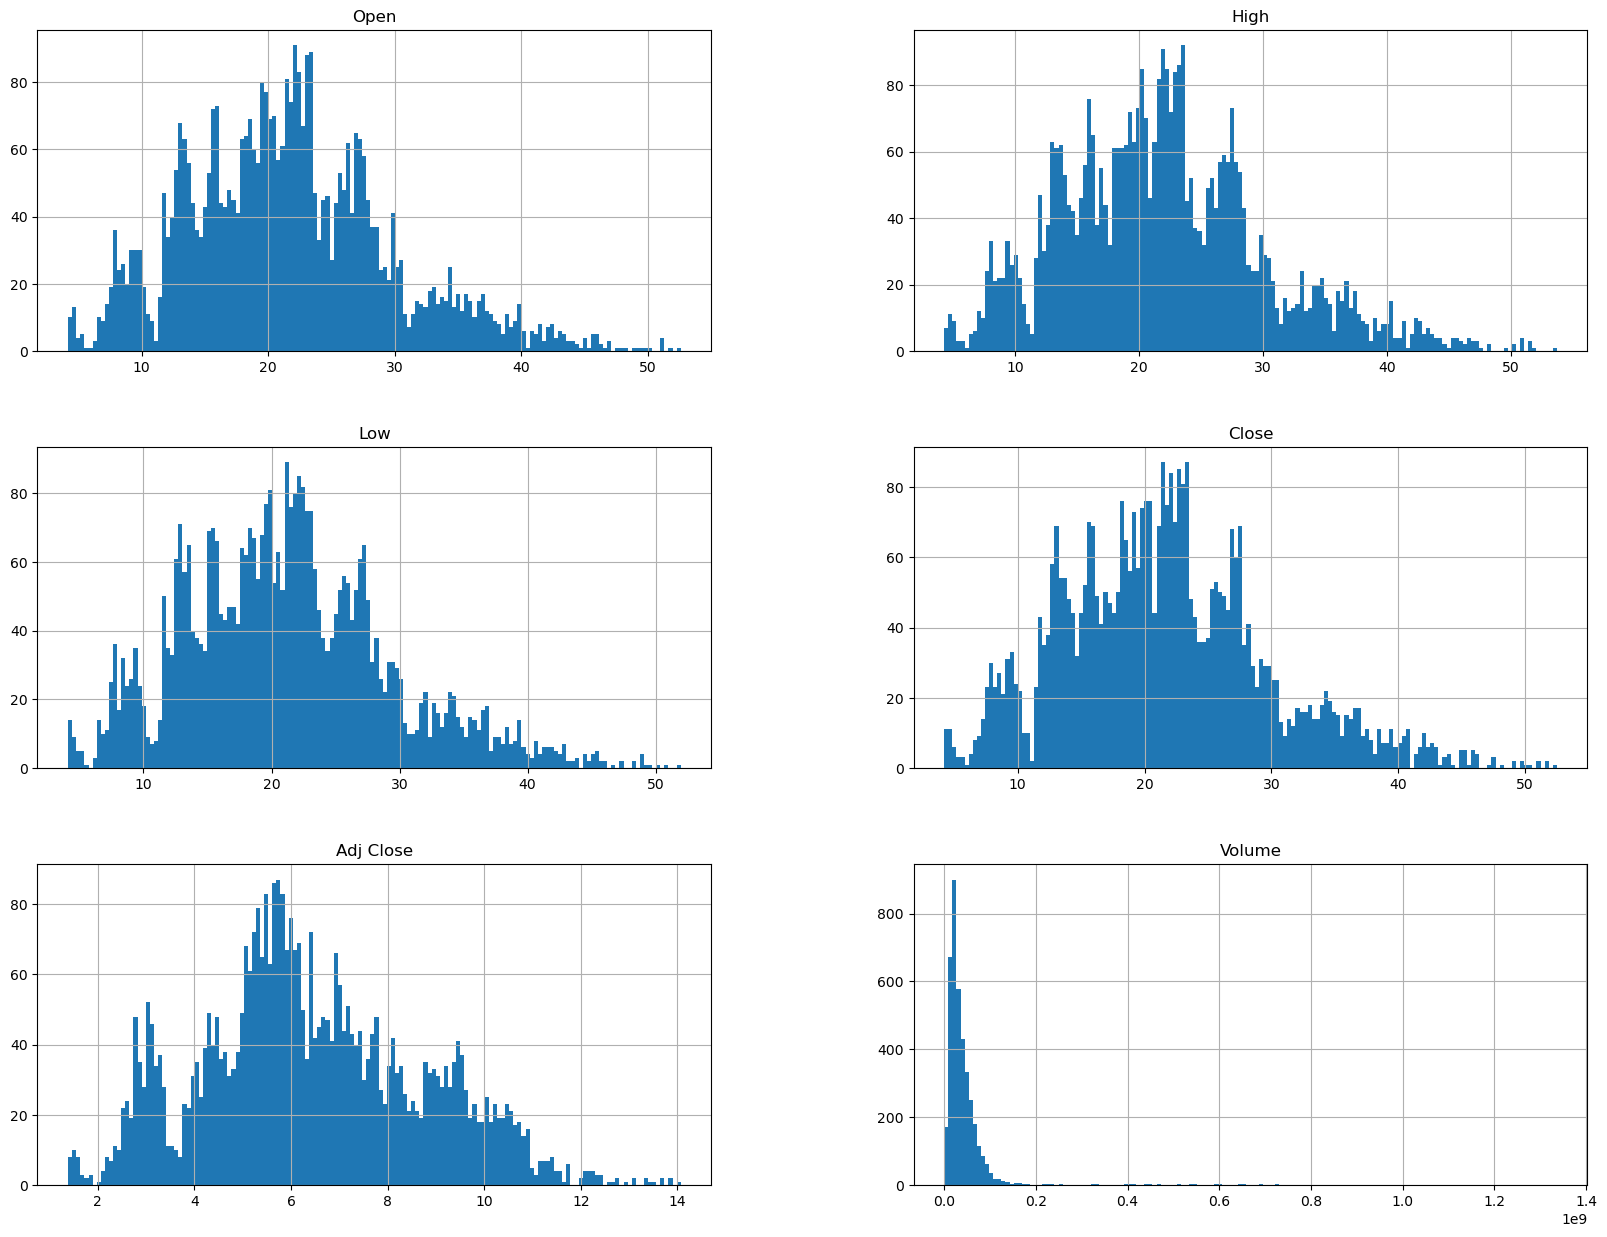

In [449]:
data.hist(bins=150, figsize=(20,15))
plt.show()

In [450]:
corr_matrix = data.corr()

In [451]:
corr_matrix['Adj Close'].sort_values(ascending=False)

Adj Close    1.000000
Close        0.947513
Low          0.947306
High         0.946366
Open         0.945893
Volume      -0.102108
Name: Adj Close, dtype: float64

Preparação dos dados

In [452]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Adj Close'].values.reshape(-1,1))

In [453]:
scaled_data

array([[0.11230986],
       [0.10967476],
       [0.10882758],
       ...,
       [0.68132675],
       [0.68385197],
       [0.68581591]])

In [454]:
days = 170

In [455]:
x_train = []
y_train = []

In [456]:
for x in range(days, len(scaled_data)):
    x_train.append(scaled_data[x-days:x, 0])
    y_train.append(scaled_data[x, 0])

In [457]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Modelo

In [458]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25


c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 0.0293
Epoch 2/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 0.0034
Epoch 3/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 0.0028
Epoch 4/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0029
Epoch 5/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0023
Epoch 6/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0024
Epoch 7/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0025
Epoch 8/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0021
Epoch 9/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0018
Epoch 10/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0017
Epoch 11/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0016
Epoch 12/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0016
Epoch 13/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0012
Epoch 14/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0014
Epoch 15/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step

In [459]:
test_data = yfin.download(tickers= ticket, start= datetime(2021,1,1), end= datetime.now())

[*********************100%%**********************]  1 of 1 completed


In [460]:
actual_price = test_data['Adj Close'].values

In [461]:
total_dataset = pd.concat((data['Adj Close'], test_data['Adj Close']), axis=0)

In [462]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - days:].values

In [463]:
model_inputs = model_inputs.reshape(-1,1)

In [464]:
model_inputs = scaler.transform(model_inputs)

In [465]:
x_test = []

In [466]:
for x in range(days, len(model_inputs) + 1):
    x_test.append(model_inputs[x-days:x, 0])


In [467]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [468]:
predicted_prices = model.predict(x_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [469]:
predicted_prices = scaler.inverse_transform(predicted_prices)

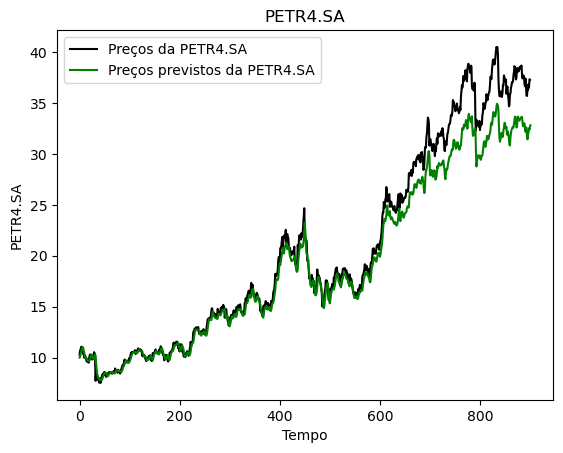

In [470]:
plt.plot(actual_price, color='black', label=f'Preços da {ticket}')
plt.plot(predicted_prices,color='green', label=f'Preços previstos da {ticket}')
plt.title(f'{ticket}')
plt.xlabel('Tempo')
plt.ylabel(f'{ticket}')
plt.legend()
plt.show()

In [471]:
real_data = [model_inputs[len(model_inputs) + 1 - days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))


In [472]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Previsão: {prediction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Previsão: [[32.822205]]


Métricas de desempenho

In [473]:
len(actual_price)

901

In [474]:
predicted_prices = predicted_prices[:-1]

In [475]:
len(predicted_prices)

901

Implementar uma métrica (medidas de desempenho) para os dados de teste
avaliar outros atrasos 
avaliar outras ações
Repetir experimentos



In [476]:
mae = mean_absolute_error(actual_price, predicted_prices)
mse = mean_squared_error(actual_price, predicted_prices)
rmse = np.sqrt(mse)
r2 = r2_score(actual_price, predicted_prices)


In [477]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 1.4061309171966654
Mean Squared Error (MSE): 4.524198645027
Root Mean Squared Error (RMSE): 2.127016371593552
R-squared (R²): 0.9514765811862751


https://scikit-learn.org/stable/modules/cross_validation.html
Guilherme Palermo Coelho
14:30
- 

### Próximos passos:

- Verificar a normalização de testes OK
- Repetir os experimentos, para depois obter média + desvio padrão de cada métrica (MSE, RMSE, …) OK
- Futuro:
    - Validação Cruzada para séries temporais. OK
    - Verificar necessidade de diferenciação da série temporal OK

Sugestão
Gráfico treinamento + teste para visualizar todo o processo do modelo OK
Colocar as barrinhas em cada ponto para indicar o desvio padrão OK
https://en.wikipedia.org/wiki/Error_bar#/media/File:Confidenceinterval.png
Ajuste de hiperparâmetros do modelo 
Variar o ativo para analisar o comportamento do modelo e como ele reage 

### Próximos passos:
- Corrigir experimentos do diferenciação → não “desdiferencia” as predições
- Também diferenciar o novo conjunto de testes.
- Apresentar os resultados médios para as k partições de validação
- Os experimentos para definição de parâmetros, como número de atrasos etc devem olhar os *folds* de validação → É nestes que você tomará as decisões
- Só no final, após todas as decisões, você irá treinar um novo modelo, usando todos os dados de treinamento, e aplicar ao novo conjunto